In [2]:
import pandas as pd
import os
from glob import glob
import scipy
from sklearn.preprocessing import quantile_transform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import numpy as np
from combat.pycombat import pycombat


In [3]:
############################################
## TCGA files
tcga_dir = "/Users/michael/cheng-project/tcga-data/tcga-gbm-rnaseq/rnaseq"
tcga_files = glob(os.path.join(tcga_dir, "*.tsv"))

tcga_dfs = []

for file in tcga_files:
    sample_name = os.path.splitext(os.path.basename(file))[0] + "_tcga"
    
    df = pd.read_csv(file, sep="\t", usecols=["gene_id", "tpm_unstranded"])
    df.rename(columns={"tpm_unstranded": sample_name}, inplace=True)
    df.set_index("gene_id", inplace=True)
    tcga_dfs.append(df)

tcga_gbm_df = pd.concat(tcga_dfs, axis=1)

############################################
## CPTAC files
cptac_dir = "/Users/michael/cheng-project/cptac-gbm/rnaseq-files/clean.tpm.files"
cptac_files = glob(os.path.join(cptac_dir, "*.tsv"))

cptac_dfs = []

for file in cptac_files:
    sample_name = os.path.splitext(os.path.basename(file))[0] + "_cptac"
    
    df = pd.read_csv(file, sep="\t", usecols=["gene_id", "tpm_unstranded"])
    df.rename(columns={"tpm_unstranded": sample_name}, inplace=True)
    df.set_index("gene_id", inplace=True)
    cptac_dfs.append(df)

cptac_gbm_df = pd.concat(cptac_dfs, axis=1)


# make combined wih teresa

# Load tumor RNA-seq file (2-column file: gene_id, tumor_rnaseq)
teresa_df = pd.read_csv("/Users/michael/cheng-project/boston-gene/rnaseq/core-rnaseq/star_rsem_gencode-v36/rsem.merged.gene_tpm.cleaned.tsv", sep="\t",
                        names=["gene_id", "teresa_gbm"], header=0).set_index("gene_id")
# Merge on gene_id to add tumor_rnaseq column
combined_with_teresa = pd.concat([tcga_gbm_df, cptac_gbm_df,teresa_df], axis=1)

combined_with_teresa_log2 = combined_with_teresa.map(lambda x: np.log2(x + 1))



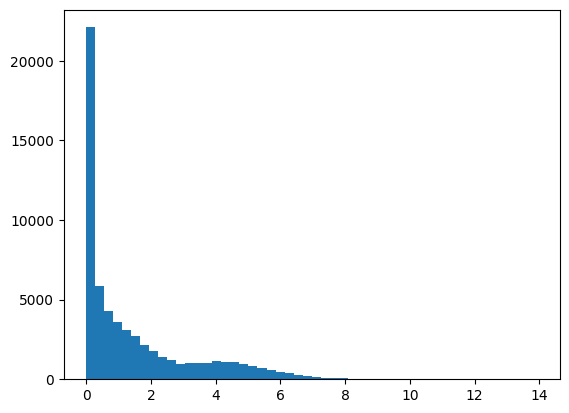

In [4]:
# histogram of average gene expression
plt.hist(combined_with_teresa_log2.mean(axis=1),bins=50)
combined_with_teresa_log2= combined_with_teresa_log2[combined_with_teresa_log2.mean(axis=1)>0.5]

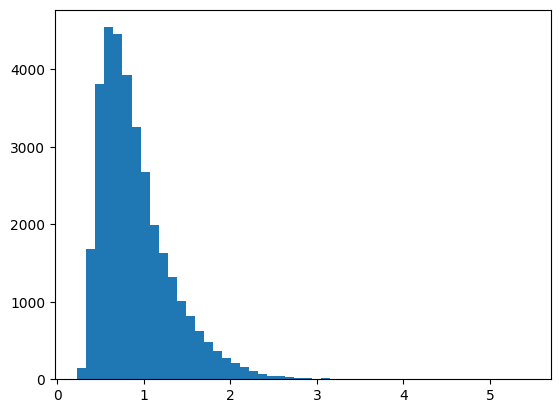

In [5]:
# histogram of std dev gene expression
plt.hist(combined_with_teresa_log2.std(axis=1),bins=50)
combined_with_teresa_log2= combined_with_teresa_log2[combined_with_teresa_log2.std(axis=1)>0.25]

In [6]:
# 🎯 Extract Teresa's TPM profile
teresa_tpm = combined_with_teresa["teresa_gbm"]

# 🎯 Identify columns by source
tcga_cols = [col for col in combined_with_teresa.columns if col.endswith("_tcga")]
cptac_cols = [col for col in combined_with_teresa.columns if col.endswith("_cptac")]

# 🎯 Compute mean TPMs
tcga_mean = combined_with_teresa[tcga_cols].mean(axis=1)
cptac_mean = combined_with_teresa[cptac_cols].mean(axis=1)

# 📊 Summary statistics
print("📊 Teresa TPM:")
print(teresa_tpm.describe())

print("\n📊 TCGA Mean TPM:")
print(tcga_mean.describe())

print("\n📊 CPTAC Mean TPM:")
print(cptac_mean.describe())

# 🔗 Correlation metrics
print("\n🔗 Correlation with TCGA:")
print(f"Pearson: {teresa_tpm.corr(tcga_mean):.4f}")
print(f"Spearman: {teresa_tpm.corr(tcga_mean, method='spearman'):.4f}")

print("\n🔗 Correlation with CPTAC:")
print(f"Pearson: {teresa_tpm.corr(cptac_mean):.4f}")
print(f"Spearman: {teresa_tpm.corr(cptac_mean, method='spearman'):.4f}")

# 🔍 Top 500 most expressed genes in each group
top500_tcga = tcga_mean.nlargest(500).index
top500_cptac = cptac_mean.nlargest(500).index

print(f"\n📈 Spearman (top 500 TCGA): {teresa_tpm[top500_tcga].corr(tcga_mean[top500_tcga], method='spearman'):.4f}")
print(f"📈 Spearman (top 500 CPTAC): {teresa_tpm[top500_cptac].corr(cptac_mean[top500_cptac], method='spearman'):.4f}")


📊 Teresa TPM:
count    60660.000000
mean        16.485327
std        109.008796
min          0.000000
25%          0.000000
50%          0.000000
75%          1.790000
max      12022.730000
Name: teresa_gbm, dtype: float64

📊 TCGA Mean TPM:
count    60660.000000
mean        16.485328
std        226.156374
min          0.000000
25%          0.021402
50%          0.222181
75%          3.164825
max      22322.595417
dtype: float64

📊 CPTAC Mean TPM:
count     60660.000000
mean         16.485328
std        1193.151333
min           0.000000
25%           0.114774
50%           1.199653
75%           7.537084
max      293090.901521
dtype: float64

🔗 Correlation with TCGA:
Pearson: 0.1860
Spearman: 0.7091

🔗 Correlation with CPTAC:
Pearson: 0.4625
Spearman: 0.6322

📈 Spearman (top 500 TCGA): 0.3079
📈 Spearman (top 500 CPTAC): 0.1357


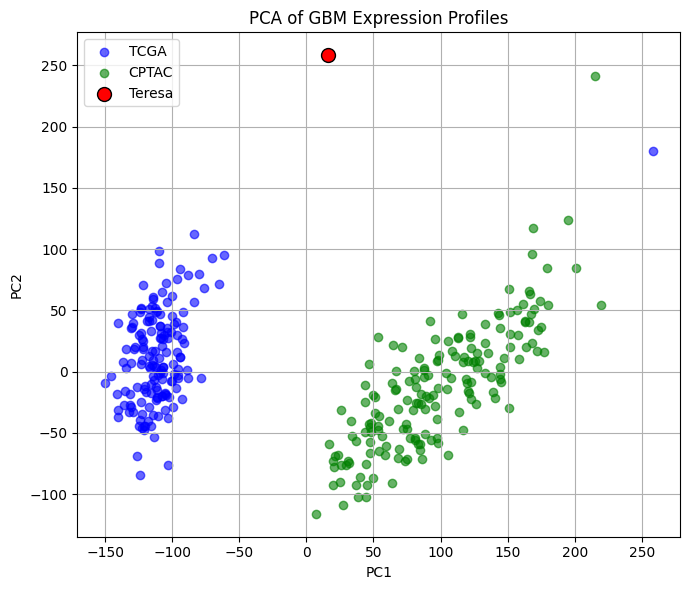

In [7]:
# 🎯 Identify sample groupsd
tcga_cols = [col for col in combined_with_teresa.columns if col.endswith("_tcga")]
cptac_cols = [col for col in combined_with_teresa.columns if col.endswith("_cptac")]
teresa_col = "teresa_gbm"

# 📦 Transpose and scale the expression matrix
X = combined_with_teresa[[*tcga_cols, *cptac_cols, teresa_col]].T.fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# 🔬 PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

# 🖼️ Plot PCA by group
plt.figure(figsize=(7, 6))

# Plot TCGA
tcga_indices = list(range(len(tcga_cols)))
plt.scatter(pca_coords[tcga_indices, 0], pca_coords[tcga_indices, 1],
            label="TCGA", alpha=0.6, color='blue')

# Plot CPTAC
cptac_indices = list(range(len(tcga_cols), len(tcga_cols) + len(cptac_cols)))
plt.scatter(pca_coords[cptac_indices, 0], pca_coords[cptac_indices, 1],
            label="CPTAC", alpha=0.6, color='green')

# Plot Teresa
teresa_index = len(tcga_cols) + len(cptac_cols)
plt.scatter(pca_coords[teresa_index, 0], pca_coords[teresa_index, 1],
            label="Teresa", color='red', s=100, edgecolor='black')

plt.title("PCA of GBM Expression Profiles")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/michael/miniconda3/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (333). n_quantiles is set to n_samples.
  warnings.warn(


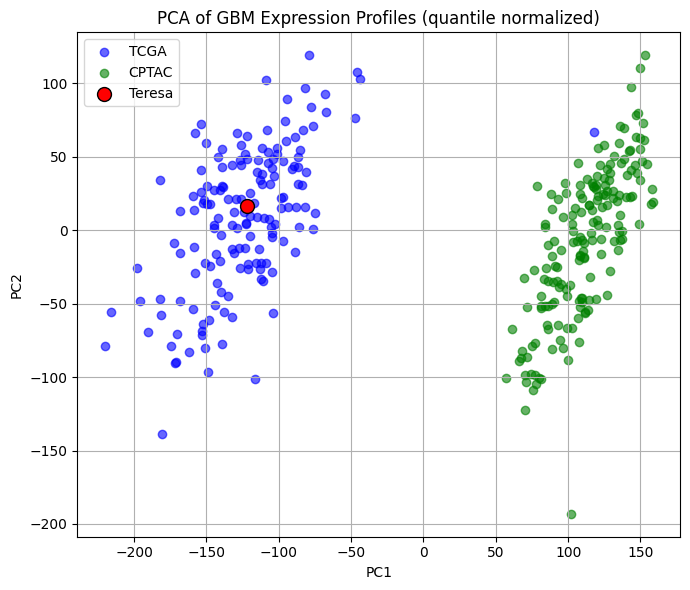

In [8]:
#### including qunatile normalization
# 🎯 Identify sample groups
tcga_cols = [col for col in combined_with_teresa.columns if col.endswith("_tcga")]
cptac_cols = [col for col in combined_with_teresa.columns if col.endswith("_cptac")]
teresa_col = "teresa_gbm"

# 📦 Transpose and fill NA
X = combined_with_teresa[[*tcga_cols, *cptac_cols, teresa_col]].T.fillna(0)

# 🔄 Quantile normalization (transform features to uniform dist, then back to normal)
X_qn = quantile_transform(X, axis=0, output_distribution='normal', copy=True)

# ⚖️ Standard scaling
X_scaled = StandardScaler().fit_transform(X_qn)

# 🔬 PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

# 🖼️ Plot PCA by group
plt.figure(figsize=(7, 6))

# Plot TCGA
tcga_indices = list(range(len(tcga_cols)))
plt.scatter(pca_coords[tcga_indices, 0], pca_coords[tcga_indices, 1],
            label="TCGA", alpha=0.6, color='blue')

# Plot CPTAC
cptac_indices = list(range(len(tcga_cols), len(tcga_cols) + len(cptac_cols)))
plt.scatter(pca_coords[cptac_indices, 0], pca_coords[cptac_indices, 1],
            label="CPTAC", alpha=0.6, color='green')

# Plot Teresa
teresa_index = len(tcga_cols) + len(cptac_cols)
plt.scatter(pca_coords[teresa_index, 0], pca_coords[teresa_index, 1],
            label="Teresa", color='red', s=100, edgecolor='black')

plt.title("PCA of GBM Expression Profiles (quantile normalized)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/michael/miniconda3/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (333). n_quantiles is set to n_samples.
  warnings.warn(


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


/Users/michael/miniconda3/lib/python3.13/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data
[[-1.57566560e-01 -1.42769208e+00 -5.31963825e-02 ... -5.41074773e-01
  -4.57779431e-01  6.75911745e-02]
 [ 7.59579469e-04 -6.41006314e-01  8.70554528e-02 ... -5.41074773e-01
   1.54466580e+00 -3.21489757e-02]
 [-1.38522114e-01  1.67787571e-01 -4.40645289e-01 ... -5.41074773e-01
   1.78049147e-02  4.28371240e-01]
 ...
 [ 2.89849444e-01  7.38132252e-01  1.10890275e+00 ...  6.89745840e-02
   1.42327664e+00  6.78546470e-02]
 [-2.04396090e+00 -7.65404574e-01 -1.54223197e+00 ...  3.60020580e-02
  -1.67990171e+00 -1.26518570e+00]
 [-6.01931427e-01 -1.49839271e+00  1.27794737e+00 ... -5.19279757e+00
  -5.46150883e+00 -2.28528015e+00]]


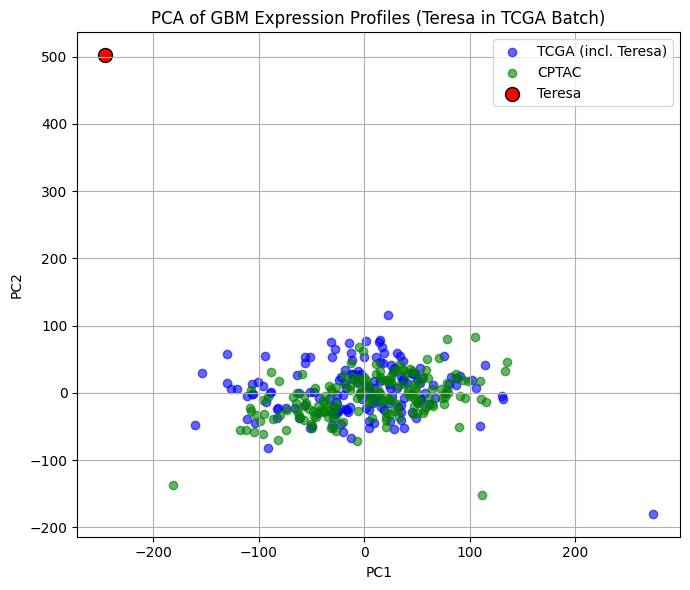

In [8]:
# 🎯 Identify sample groups
tcga_cols = [col for col in combined_with_teresa.columns if col.endswith("_tcga")]
cptac_cols = [col for col in combined_with_teresa.columns if col.endswith("_cptac")]
teresa_col = "teresa_gbm"

# 📦 Assemble expression matrix (samples x genes)
all_cols = [*tcga_cols, *cptac_cols, teresa_col]
X = combined_with_teresa_log2[all_cols].T.fillna(0)

# 🔄 Quantile normalization (samples x genes)
X_qn = quantile_transform(X, axis=0, output_distribution='normal', copy=True)
X_qn_df = pd.DataFrame(X_qn, index=X.index, columns=X.columns)

# 🔁 Transpose for ComBat: genes x samples
X_qn_transposed = X_qn_df.T

# 🧾 Create batch labels, treating Teresa as part of TCGA
batch_labels = ['tcga'] * (len(tcga_cols) + 1) + ['cptac'] * len(cptac_cols)
assert len(batch_labels) == X_qn_transposed.shape[1]

# 🧹 Apply ComBat
X_combat = pycombat(X_qn_transposed, batch=batch_labels)

# 🔁 Transpose back to samples x genes
X_combat_df = X_combat.T

# ⚖️ Standard scaling
X_scaled = StandardScaler().fit_transform(X_combat_df)

print(X_scaled)
exit()

# 🔬 PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

# 🖼️ Plot PCA by group
plt.figure(figsize=(7, 6))

# Plot TCGA (including Teresa)
tcga_indices = list(range(len(tcga_cols))) + [len(tcga_cols) + len(cptac_cols)]
plt.scatter(pca_coords[tcga_indices, 0], pca_coords[tcga_indices, 1],
            label="TCGA (incl. Teresa)", alpha=0.6, color='blue')

# Plot CPTAC
cptac_indices = list(range(len(tcga_cols), len(tcga_cols) + len(cptac_cols)))
plt.scatter(pca_coords[cptac_indices, 0], pca_coords[cptac_indices, 1],
            label="CPTAC", alpha=0.6, color='green')

# Highlight Teresa
teresa_index = len(tcga_cols) + len(cptac_cols)
plt.scatter(pca_coords[teresa_index, 0], pca_coords[teresa_index, 1],
            label="Teresa", color='red', s=100, edgecolor='black')

plt.title("PCA of GBM Expression Profiles (Teresa in TCGA Batch)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/michael/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/michael/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


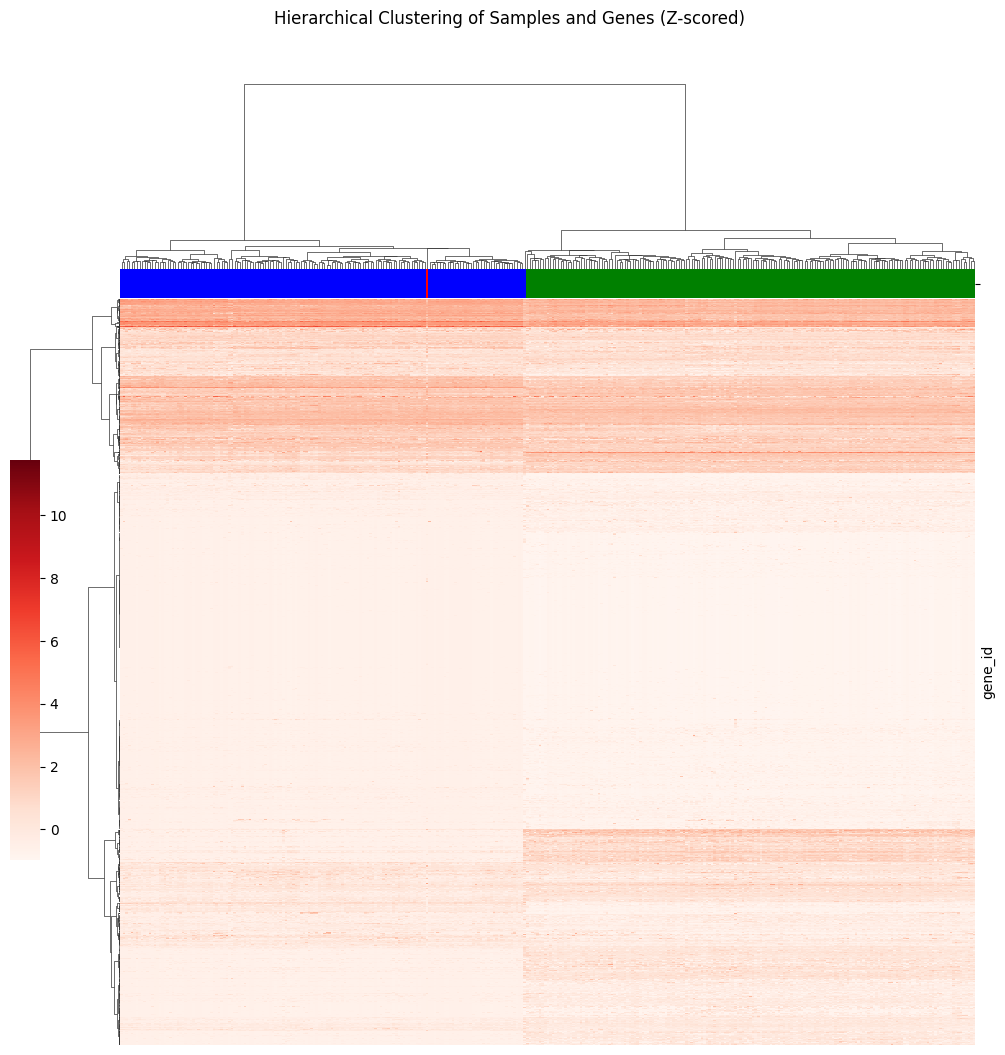

In [17]:
# 🧼 Remove genes with any missing values
combined_with_teresa = combined_with_teresa.dropna(axis=0, how="any")

# 🎲 Sample 15,000 genes for visualization
sampled_df = combined_with_teresa.sample(n=15000, random_state=42)
# sampled_df = combined_with_teresa.sample(n=5000, random_state=42)

# 🎨 Assign colors based on sample group
def color_sample(col):
    if col.endswith('_tcga'):
        return 'blue'
    elif col.endswith('_cptac'):
        return 'green'
    elif col == 'teresa_gbm':
        return 'red'
    else:
        return 'gray'

col_colors = pd.Series([color_sample(col) for col in sampled_df.columns], index=sampled_df.columns)

# 📊 Clustermap with log2(TPM+1) transform + Z-score across genes
sns.clustermap(
    sampled_df.map(lambda x: np.log2(x + 1)),
    z_score=1,               # Row-wise Z-score (genes)
    method='ward',
    metric='euclidean',
    cmap='Reds',
    figsize=(10, 10),
    xticklabels=False,
    yticklabels=False,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(0, .2, .03, .4),
    col_colors=col_colors
)

plt.suptitle("Hierarchical Clustering of Samples and Genes (Z-scored)", y=1.05)
plt.show()

/Users/michael/miniconda3/lib/python3.13/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


ValueError: The number of observations cannot be determined on an empty distance matrix.

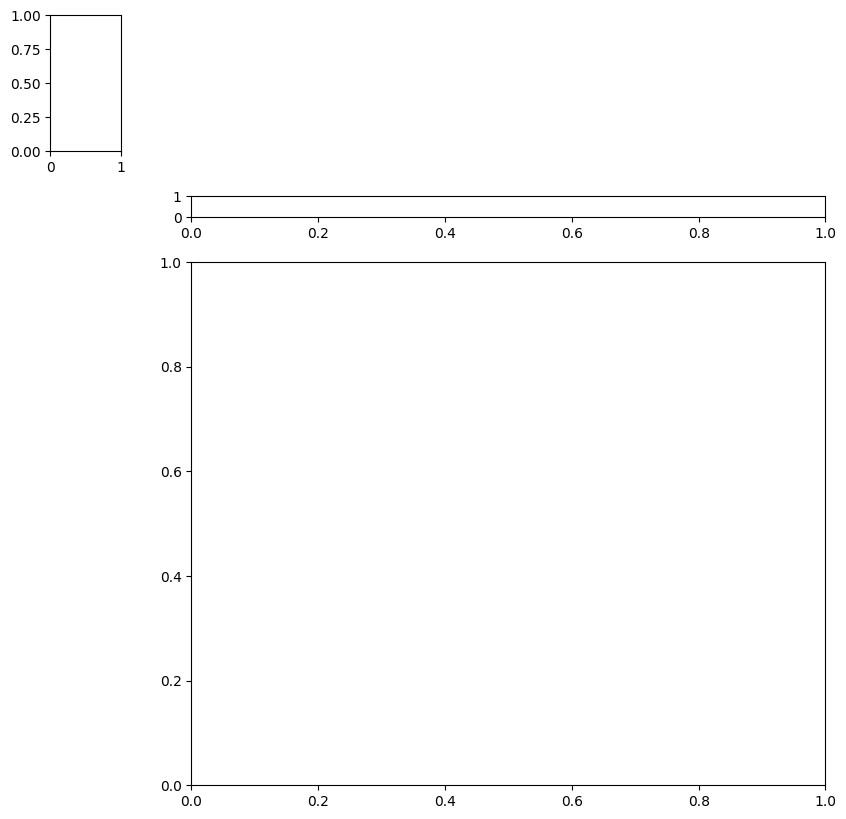

In [14]:
from sklearn.preprocessing import quantile_transform

# 🧼 Remove genes with any missing values
combined_with_teresa = combined_with_teresa.dropna(axis=0, how="any")

# 🎲 Sample 15,000 genes for visualization
sampled_df = combined_with_teresa.sample(n=15000, random_state=42)

# ✅ Quantile normalization (samples x genes → then transpose back)
sampled_qn = pd.DataFrame(
    quantile_transform(
        sampled_df.T,
        n_quantiles=sampled_df.shape[1],
        output_distribution='normal',
        copy=True
    ),
    index=sampled_df.columns,
    columns=sampled_df.index
).T

# ✅ Replace inf/-inf and drop any rows with NaNs after log2
sampled_qn_log2 = np.log2(sampled_qn + 1)
sampled_qn_log2 = sampled_qn_log2.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how='any')

# 🎨 Assign colors based on sample group
def color_sample(col):
    if col.endswith('_tcga'):
        return 'blue'
    elif col.endswith('_cptac'):
        return 'green'
    elif col == 'teresa_gbm':
        return 'red'
    else:
        return 'gray'

col_colors = pd.Series([color_sample(col) for col in sampled_qn_log2.columns], index=sampled_qn_log2.columns)

# 📊 Clustermap
sns.clustermap(
    sampled_qn_log2,
    z_score=1,  # Row-wise Z-score
    method='ward',
    metric='euclidean',
    cmap='Reds',
    figsize=(10, 10),
    xticklabels=False,
    yticklabels=False,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(0, .2, .03, .4),
    col_colors=col_colors
)

plt.suptitle("Hierarchical Clustering of Samples and Genes (Quantile-normalized, Z-scored)", y=1.05)
plt.show()
